# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 4: Regularization and Model Selection

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Hayden Joy<br/>

<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
from IPython.display import Image

For this section, our goal is to get you familiarized with Regularization in Multiple Linear Regression and to start thinking about Model and Hyper-Parameter Selection. 

Specifically, we will:

- Load in the King County House Price Dataset
- Perform some basic EDA
- Split the data up into a training, **validation**, and test set (we'll see why we need a validation set)
- Scale the variables (by standardizing or normalizing them) and seeing why we need to do this
- Make our multiple & polynomial regression models (like we did in the previous section)
- Learn what **regularization** is and how it can help
- Understand **ridge** and **lasso** regression
- Get an introduction to **cross-validation** using RidgeCV and LassoCV

<img src="fig/meme.png" width="400">

In [2]:
# Data and Stats packages
import numpy as np
import pandas as pd
pd.set_option('max_columns', 200)

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#from prettytable import PrettyTable



# EDA: House Prices Data From Kaggle

For our dataset, we'll be using the house price dataset from [King County, WA](https://en.wikipedia.org/wiki/King_County,_Washington). The dataset is from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). 

The task is to build a regression model to **predict the price**, based on different attributes. First, let's do some EDA.

In [3]:
# Load the dataset 
house_df = pd.read_csv('../data/kc_house_data.csv')
house_df = house_df.sample(frac=1, random_state=42)[0:4000]
print(house_df.shape)
print(house_df.dtypes)
house_df.head()

(4000, 21)
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
735,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
2830,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
4106,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
16218,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
19964,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


Now let's check for null values and look at the datatypes within the dataset.

In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 735 to 3455
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             4000 non-null   int64  
 1   date           4000 non-null   object 
 2   price          4000 non-null   float64
 3   bedrooms       4000 non-null   int64  
 4   bathrooms      4000 non-null   float64
 5   sqft_living    4000 non-null   int64  
 6   sqft_lot       4000 non-null   int64  
 7   floors         4000 non-null   float64
 8   waterfront     4000 non-null   int64  
 9   view           4000 non-null   int64  
 10  condition      4000 non-null   int64  
 11  grade          4000 non-null   int64  
 12  sqft_above     4000 non-null   int64  
 13  sqft_basement  4000 non-null   int64  
 14  yr_built       4000 non-null   int64  
 15  yr_renovated   4000 non-null   int64  
 16  zipcode        4000 non-null   int64  
 17  lat            4000 non-null   float64
 18  long  

In [5]:
house_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,4.000000e+03,4.000000e+03,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.00000
mean,4.586542e+09,5.497522e+05,3.379250,2.116563,2096.645250,1.616511e+04,1.475000,0.007750,0.232500,3.420750,7.668250,1792.465000,304.18025,1970.564250,89.801500,98078.035500,47.560091,-122.214060,1997.75900,12790.67800
std,2.876700e+09,3.890505e+05,0.922568,0.783175,957.785141,5.120888e+04,0.530279,0.087703,0.768174,0.646393,1.194173,849.986192,455.26354,29.141872,413.760082,54.073374,0.139070,0.141879,701.60987,26085.20301
min,1.000102e+06,8.250000e+04,0.000000,0.000000,384.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,384.000000,0.00000,1900.000000,0.000000,98001.000000,47.155900,-122.515000,620.00000,659.00000
25%,2.126074e+09,3.249500e+05,3.000000,1.750000,1420.000000,5.200000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.00000,1951.000000,0.000000,98033.000000,47.468175,-122.328000,1490.00000,5200.00000
50%,3.889350e+09,4.550000e+05,3.000000,2.250000,1920.000000,7.675000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1550.000000,0.00000,1974.500000,0.000000,98065.000000,47.573800,-122.231000,1840.00000,7628.00000
75%,7.334526e+09,6.541250e+05,4.000000,2.500000,2570.000000,1.087125e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2250.000000,590.00000,1995.000000,0.000000,98118.000000,47.679100,-122.127000,2370.00000,10240.00000
max,9.842300e+09,5.570000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.00000,2015.000000,2015.000000,98199.000000,47.777500,-121.315000,5790.00000,560617.00000


Let's choose a subset of columns here. **NOTE**: The way I'm selecting columns here is not principled and is just for convenience. In your homework assignments (and in real life), we expect you to choose columns more rigorously.

1. `bedrooms`
2. `bathrooms`
3. `sqft_living`
4. `sqft_lot`
5. `floors`
6. `sqft_above`
7. `sqft_basement`
8. `lat`
9. `long`
10. **`price`**: Our response variable

In [6]:
cols_of_interest = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
                    'lat', 'long', 'price']
house_df = house_df[cols_of_interest]

# Convert house price to 1000s of dollars
house_df['price'] = house_df['price']/1000

Let's see how the response variable (`price`) is distributed

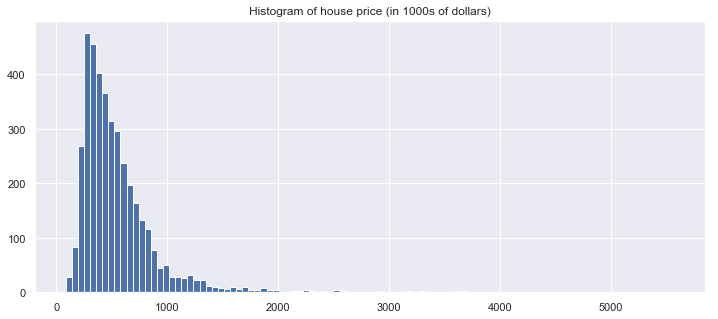

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(house_df['price'], bins=100)
ax.set_title('Histogram of house price (in 1000s of dollars)');

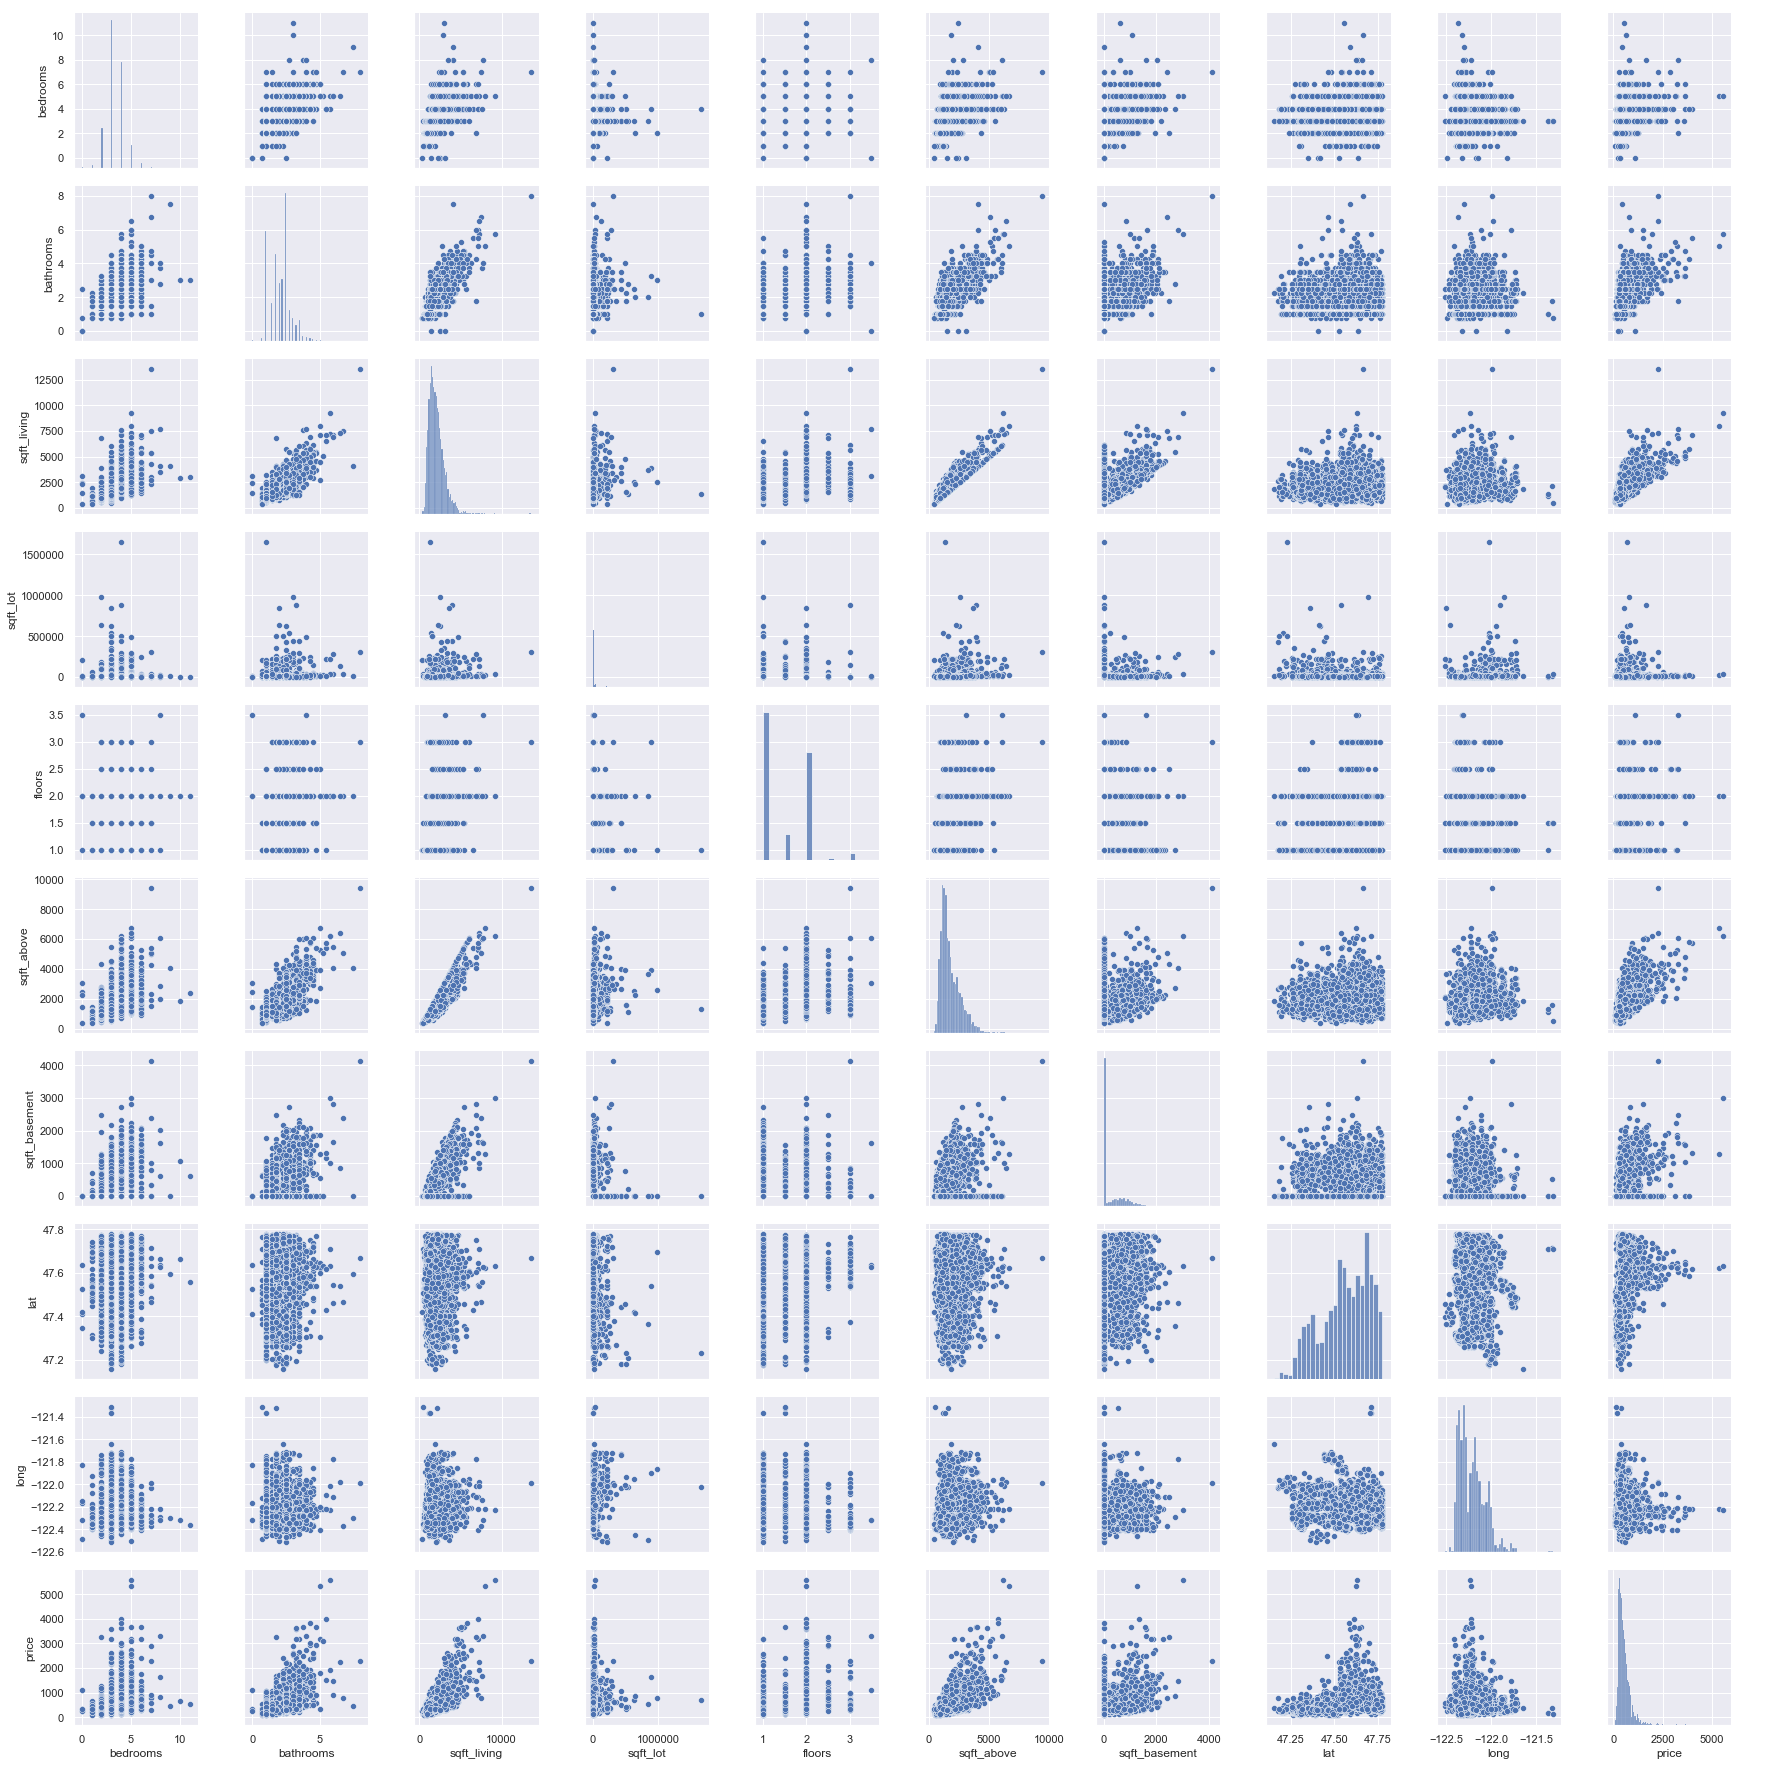

In [8]:
# This takes a bit of time but is worth it!!
sns.pairplot(house_df);

## Train-Validation-Test Split

Up until this point, we have only had a train-test split. Why are we introducing a validation set? What's the point?

This is the general idea: 

1. **Training Set**: Data you have seen. You train different types of models with various different hyper-parameters and regularization parameters on this data. 


2. **Validation Set**: Used to compare different models. We use this step to tune our hyper-parameters i.e. find the optimal set of hyper-parameters (such as $k$ for k-NN or our $\beta_i$ values or number of degrees of our polynomial for linear regression). Pick your best model here. 



3. **Test Set**: Using the best model from the previous step, simply report the score e.g. $R^2$ score, MSE or any metric that you care about, of that model on your test set. **DON'T TUNE YOUR PARAMETERS HERE!**. Why, I hear you ask? Because we want to know how our model might do on data it hasn't seen before. We don't have access to this data (because it may not exist yet) but the test set, which we haven't seen or touched so far, is a good way to mimic this new data. 

Let's do 60% train, 20% validation, 20% test for this dataset.

In [9]:
from sklearn.model_selection import train_test_split

# first split the data into a train-test split and don't touch the test set yet
train_df, test_df = train_test_split(house_df, test_size=0.2, random_state=42)

# next, split the training set into a train-validation split
# the test-size is 0.25 since we are splitting 80% of the data into 20% and 60% overall
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print('Train Set: {0:0.2f}%'.format(100*train_df.size/house_df.size))
print('Validation Set: {0:0.2f}%'.format(100*val_df.size/house_df.size))
print('Test Set: {0:0.2f}%'.format(100*test_df.size/house_df.size))

Train Set: 60.00%
Validation Set: 20.00%
Test Set: 20.00%


# Modeling

In the [last section](https://github.com/Harvard-IACS/2019-CS109A/tree/master/content/sections/section3), we went over the mechanics of Multiple Linear Regression and created models that had interaction terms and polynomial terms. Specifically, we dealt with the following sorts of models. 

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_M x_M + \epsilon
$$

Let's adopt a similar process here and get a few different models.

## Creating a Design Matrix

From our model setup in the equation in the previous section, we obtain the following: 

$$
Y = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}, \quad X = \begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n} \\
\end{bmatrix} = \begin{bmatrix}
x_{1,1} & x_{1,2} & \dots & x_{1,M} \\
x_{2,1} & x_{2,2} & \dots & x_{2,M} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1} & x_{n,2} & \dots & x_{n,M} \\
\end{bmatrix}, \quad \beta = \begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_M
\end{bmatrix}, \quad \epsilon = \begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n
\end{bmatrix},
$$

$X$ is an n$\times$M matrix: this is our **design matrix** (and ${x_1}$ is a vector consisting of the values of the predictors for the first data point), $\beta$ is an M-dimensional vector (an M$\times$1 matrix), and $Y$ is an n-dimensional vector (an n$\times$1 matrix). In addition, we know that $\epsilon$ is an n-dimensional vector (an n$\times$1 matrix).

We have $M$ predictors and $n$ data points.

In [10]:
X = train_df[cols_of_interest]
y = train_df['price']
print(X.shape)
print(y.shape)

(2400, 10)
(2400,)


## Scaling our Design Matrix

### Warm-Up Exercise
<img src="fig/apt_example.png" width="400">
$$\text{Euclidean Distance} : \sqrt{ (X_{1A}-X_{1B})^2 + (X_{2A} - X_{2B})^2 }$$


Warm-Up Exercise: for which of the following do the units of the predictors matter (e.g., trip length in minutes vs seconds; temperature in F or C)? A similar question would be: for which of these models do the magnitudes of values taken by different predictors matter? 

(We will go over Ridge and Lasso Regression in greater detail later)

- k-NN (Nearest Neighbors regression)
- Linear regression
- Lasso regression
- Ridge regression

**Solutions**

- kNN: **yes**. Scaling affects distance metric, which determines what "neighbor" means
- Linear regression: **no**. Multiply predictor by $c$ -> divide coef by $c$.
- Lasso: **yes**: If we divided coef by $c$, then corresponding penalty term is also divided by $c$.
- Ridge: **yes**: Same as Lasso, except penalty divided by $c^2$.

### Standard Scaler (Standardization)
 
[Here's](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) the scikit-learn implementation of the standard scaler. What is it doing though? Hint: you may have seen this in STAT 110 or another statistics course multiple times.

$$
z = \frac{x-\mu}{\sigma}
$$

In the above setup: 

- $z$ is the standardized variable
- $x$ is the variable before standardization
- $\mu$ is the mean of the variable before standardization
- $\sigma$ is the standard deviation of the variable before standardization

Let's see an example of how this works:

,x,z_manual,z_sklearn
count,4000.000000,4.000000e+03,4.000000e+03
mean,2096.645250,-2.775558e-17,-4.096723e-17
std,957.785141,1.000000e+00,1.000125e+00
min,384.000000,-1.788131e+00,-1.788355e+00
25%,1420.000000,-7.064687e-01,-7.065571e-01
50%,1920.000000,-1.844310e-01,-1.844540e-01
75%,2570.000000,4.942181e-01,4.942799e-01
max,13540.000000,1.194773e+01,1.194922e+01


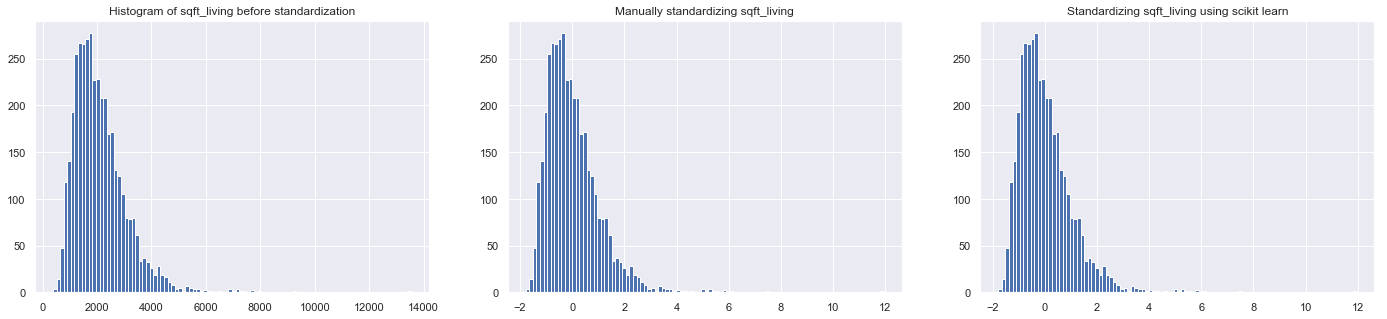

In [11]:
from sklearn.preprocessing import StandardScaler

x = house_df['sqft_living']
mu = x.mean()
sigma = x.std()
z = (x-mu)/sigma

# reshaping x to be a n by 1 matrix since that's how scikit learn likes data for standardization
x_reshaped = np.array(x).reshape(-1,1)
z_sklearn = StandardScaler().fit_transform(x_reshaped)

# Plotting the histogram of the variable before standardization
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax = ax.ravel()

ax[0].hist(x, bins=100)
ax[0].set_title('Histogram of sqft_living before standardization')

ax[1].hist(z, bins=100)
ax[1].set_title('Manually standardizing sqft_living')

ax[2].hist(z_sklearn, bins=100)
ax[2].set_title('Standardizing sqft_living using scikit learn');

# making things a dataframe to check if they work
pd.DataFrame({'x': x, 'z_manual': z, 'z_sklearn': z_sklearn.flatten()}).describe()

### Min-Max Scaler (Normalization)

[Here's](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) the scikit-learn implementation of the standard scaler. What is it doing though? 

$$
x_{new} = \frac{x-x_{min}}{x_{max}-x_{min}}
$$

In the above setup: 

- $x_{new}$ is the normalized variable
- $x$ is the variable before normalized
- $x_{max}$ is the max value of the variable before normalization
- $x_{min}$ is the min value of the variable before normalization

Let's see an example of how this works:

,x,x_new_manual,x_new_sklearn
count,4000.000000,4000.000000,4000.000000
mean,2096.645250,0.130180,0.130180
std,957.785141,0.072802,0.072802
min,384.000000,0.000000,0.000000
25%,1420.000000,0.078747,0.078747
50%,1920.000000,0.116753,0.116753
75%,2570.000000,0.166160,0.166160
max,13540.000000,1.000000,1.000000


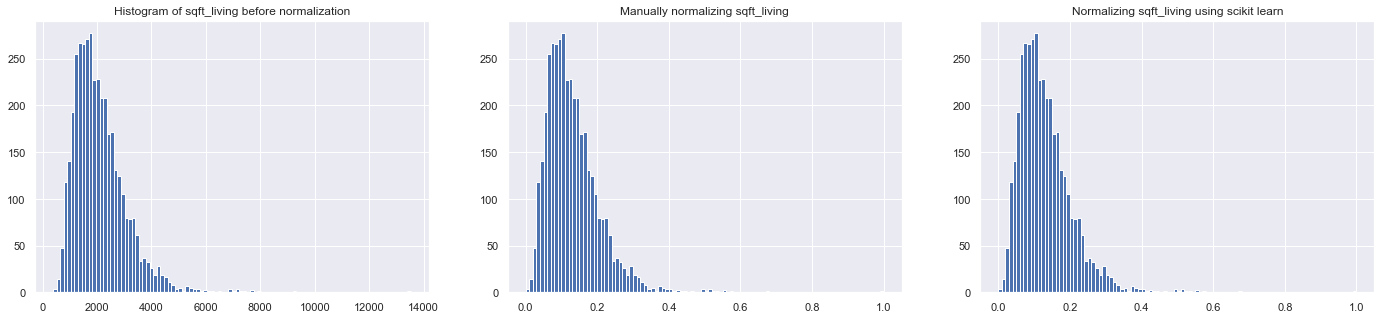

In [12]:
from sklearn.preprocessing import MinMaxScaler

x = house_df['sqft_living']
x_new = (x-x.min())/(x.max()-x.min())

# reshaping x to be a n by 1 matrix since that's how scikit learn likes data for normalization
x_reshaped = np.array(x).reshape(-1,1)
x_new_sklearn = MinMaxScaler().fit_transform(x_reshaped)

# Plotting the histogram of the variable before normalization
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax = ax.ravel()

ax[0].hist(x, bins=100)
ax[0].set_title('Histogram of sqft_living before normalization')

ax[1].hist(x_new, bins=100)
ax[1].set_title('Manually normalizing sqft_living')

ax[2].hist(x_new_sklearn, bins=100)
ax[2].set_title('Normalizing sqft_living using scikit learn');

# making things a dataframe to check if they work
pd.DataFrame({'x': x, 'x_new_manual': x_new, 'x_new_sklearn': x_new_sklearn.flatten()}).describe()

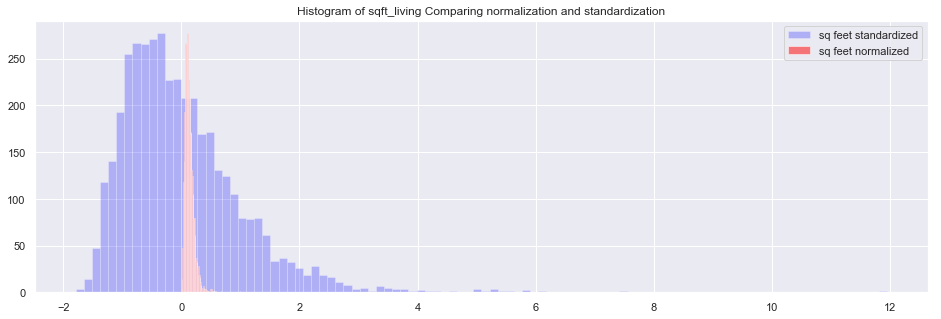

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
ax.hist((x - np.mean(x))/np.std(x), bins=100, alpha = 0.25, label = "sq feet standardized", color = "blue")
ax.hist(x_new, bins=100, label = "sq feet normalized", color = "red", alpha = .5)

ax.set_title('Histogram of sqft_living Comparing normalization and standardization')
plt.legend()

**The million dollar question**

Should I standardize or normalize my data? [This](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc), [this](https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff) and [this](https://stackoverflow.com/questions/32108179/linear-regression-normalization-vs-standardization) are useful resources that I highly recommend. But in a nutshell, what they say is the following: 

**Pros of Normalization**

1. Normalization (which makes your data go from 0-1) is widely used in image processing and computer vision, where pixel intensities are non-negative and are typically scaled from a 0-255 scale to a 0-1 range for a lot of different algorithms. 
2. Normalization is also very useful in neural networks (which we will see later in the course) as it leads to the algorithms converging faster. #next semester also we will see
3. Normalization is useful when your data does not have a discernible distribution and you are not making assumptions about your data's distribution.

**Pros of Standardization**

1. Standardization maintains outliers (do you see why?) whereas normalization makes outliers less obvious. In applications where outliers are useful, standardization should be done.
2. Standardization is useful when you assume your data comes from a Gaussian distribution (or something that is approximately Gaussian). 

**Some General Advice**

1. We use the data to calculate the parameters for standardization ($\mu$ and $\sigma$) and for normalization ($x_{min}$ and $x_{max}$). Make sure these parameters are learned on the training set i.e use the training set parameters even when normalizing/standardizing the test set. In sklearn terms, fit your scaler on the training set and use the scaler to transform your test set and validation set (**don't re-fit your scaler on test set data!**).
2. The point of standardization and normalization is to make your variables take on a more manageable scale. You should ideally standardize or normalize all your variables at the same time. 
3. Standardization and normalization is not always needed and is not an automatic thing you have to do on any data science homework!! Do so sparingly and try to justify why this is needed.

**Interpreting Coefficients**

A great quote from [here](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia)

> [Standardization] makes it so the intercept term is interpreted as the expected value of 𝑌𝑖 when the predictor values are set to their means. Otherwise, the intercept is interpreted as the expected value of 𝑌𝑖 when the predictors are set to 0, which may not be a realistic or interpretable situation (e.g. what if the predictors were height and weight?)

### Standardizing our Design Matrix

In [28]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
            'lat', 'long']

X_train = train_df[features]
y_train = np.array(train_df['price']).reshape(-1,1)

X_val = val_df[features]
y_val = np.array(val_df['price']).reshape(-1,1)

X_test = test_df[features]
y_test = np.array(test_df['price']).reshape(-1,1)

scaler = StandardScaler().fit(X_train)

# This converts our matrices into numpy matrices
X_train_t = scaler.transform(X_train)
X_val_t = scaler.transform(X_val)
X_test_t = scaler.transform(X_test)

# Making the numpy matrices pandas dataframes
X_train_df = pd.DataFrame(X_train_t, columns=features)
X_val_df = pd.DataFrame(X_val_t, columns=features)
X_test_df = pd.DataFrame(X_test_t, columns=features)

display(X_train_df.describe())
display(X_val_df.describe())
display(X_test_df.describe())

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,2.250977e-16,4.503342e-17,1.471971e-16,-2.406640e-17,2.680263e-16,-8.234154e-18,-1.709281e-16,4.928733e-14,4.897231e-14
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-3.618993e+00,-2.677207e+00,-1.766429e+00,-3.364203e-01,-8.897850e-01,-1.636285e+00,-6.704685e-01,-2.937091e+00,-2.084576e+00
25%,-4.009185e-01,-4.598398e-01,-7.087691e-01,-2.324570e-01,-8.897850e-01,-7.089826e-01,-6.704685e-01,-6.732889e-01,-8.086270e-01
50%,-4.009185e-01,1.736938e-01,-1.933403e-01,-1.774091e-01,-8.897850e-01,-2.895998e-01,-6.704685e-01,8.468878e-02,-1.278830e-01
75%,6.717731e-01,4.904606e-01,4.973342e-01,-1.033061e-01,9.975186e-01,5.375162e-01,6.315842e-01,8.607566e-01,6.455277e-01
max,7.107923e+00,7.459330e+00,1.179553e+01,1.945618e+01,3.828474e+00,8.878574e+00,8.291994e+00,1.560846e+00,6.062967e+00


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.018772,0.041444,0.024401,0.016506,0.026737,0.044415,-0.031370,-0.056059,0.016900
std,0.982683,0.997594,0.989079,1.074079,0.991645,0.993807,0.999638,1.008010,1.028649
min,-2.546302,-1.726907,-1.626232,-0.328715,-0.889785,-1.477851,-0.670469,-2.693960,-2.141602
25%,-0.400918,-0.459840,-0.677843,-0.234254,-0.889785,-0.685684,-0.670469,-0.737509,-0.815755
50%,-0.400918,0.173694,-0.172723,-0.177521,0.053867,-0.266301,-0.670469,0.031504,-0.088678
75%,0.671773,0.490461,0.487026,-0.113533,0.997519,0.595764,0.550206,0.817340,0.597412
max,8.180614,4.925195,7.321611,21.716593,2.884822,5.139078,5.839795,1.554333,6.369480


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.010727,-0.018346,-0.029080,0.052808,0.006684,-0.021866,-0.020484,-0.005631,0.000897
std,0.965422,0.963162,0.946367,1.569619,1.012587,0.955805,0.938793,1.022830,1.028155
min,-3.618993,-2.677207,-1.657158,-0.335005,-0.889785,-1.524449,-0.670469,-2.656332,-1.778063
25%,-0.400918,-0.459840,-0.701038,-0.229160,-0.889785,-0.708983,-0.670469,-0.624084,-0.789024
50%,-0.400918,0.173694,-0.183032,-0.174051,-0.889785,-0.295425,-0.670469,0.174054,-0.174216
75%,0.671773,0.490461,0.417443,-0.100683,0.997519,0.479269,0.588182,0.842124,0.604540
max,4.962540,3.658128,5.785633,36.746809,3.828474,5.010933,4.016921,1.544926,6.412249


In [29]:
scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

## One-Degree Polynomial Model

In [30]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

model_1 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     422.3
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:01:43   Log-Likelihood:                -2348.5
No. Observations:                2400   AIC:                             4715.
Df Residuals:                    2391   BIC:                             4767.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.118e-15      0.013  -3.89e-13      1.000      -0.026       0.026
bedrooms         -0.1592      0.017     -9.505      0.000      -0.192      -0.126
bathrooms         0.0422      0.022      1.914      0.056      -0.001       0.085
sqft_living       0.4011      0.011     36.238      0.000       0.379       0.423
sqft_lot         -0.0058      0.014     -0.420      0.675      -0.033       0.021
floors           -0.0470      0.017     -2.690      0.007      -0.081      -0.013
sqft_above        0.3866      0.013     30.254      0.000       0.362       0.412
sqft_basement     0.1242      0.014      8.651      0.000       0.096       0.152
lat               0.2414      0.013     17.983      0.000       0.215       0.268
long             -0.1388      0.014     -9.605      0.000      -0.167      -0.110
==============================================================================
Omnibus:                     1646.401   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52596.394
Skew:                           2.797   Prob(JB):                         0.00
Kurtosis:                      25.241   Cond. No.                     8.22e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.24e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Two-Degree Polynomial Model

In [31]:
def add_square_terms(df):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        df['{}^2'.format(col)] = df[col]**2
    return df

X_train_df_2 = add_square_terms(X_train)
X_val_df_2 = add_square_terms(X_val)

# Standardizing our added coefficients
cols = X_train_df_2.columns
scaler = StandardScaler().fit(X_train_df_2)
X_train_df_2 = pd.DataFrame(scaler.transform(X_train_df_2), columns=cols)
X_val_df_2 = pd.DataFrame(scaler.transform(X_val_df_2), columns=cols)

print(X_train_df.shape, X_train_df_2.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_2.head()

(2400, 9) (2400, 18)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,bedrooms^2,bathrooms^2,sqft_living^2,sqft_lot^2,floors^2,sqft_above^2,sqft_basement^2,lat^2,long^2
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.670469,-0.261919,-1.179294,-0.462425,-0.498149,-0.435619,-0.081332,-0.820725,-0.317640,-0.429442,-0.263451,1.180094
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,-0.670469,0.525365,0.289117,-0.462425,0.962623,0.551247,-0.079773,0.882097,1.104202,-0.429442,0.524670,-0.289785
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,1.499619,0.720739,0.545733,0.533184,0.286055,-0.174327,-0.080898,-0.820725,-0.625213,0.965746,0.720531,-0.546402
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,-0.670469,0.066599,-0.088678,-0.462425,0.286055,-0.217531,-0.076044,-0.820725,-0.003426,-0.429442,0.065197,0.088151
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,0.154165,-1.411729,0.232092,-0.462425,0.286055,-0.332701,-0.081403,-0.820725,-0.436000,-0.227977,-1.411246,-0.232748


In [32]:
model_2 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df_2)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     220.8
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:01:45   Log-Likelihood:                -2269.9
No. Observations:                2400   AIC:                             4576.
Df Residuals:                    2382   BIC:                             4680.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.174e-12      0.013  -4.84e-10      1.000      -0.025       0.025
bedrooms           -0.1271      0.058     -2.186      0.029      -0.241      -0.013
bathrooms           0.1537      0.060      2.569      0.010       0.036       0.271
sqft_living         0.3406      0.026     12.895      0.000       0.289       0.392
sqft_lot           -0.0278      0.030     -0.920      0.358      -0.087       0.032
floors             -0.1006      0.087     -1.151      0.250      -0.272       0.071
sqft_above          0.2460      0.036      6.809      0.000       0.175       0.317
sqft_basement       0.2587      0.033      7.758      0.000       0.193       0.324
lat                83.5852      8.613      9.705      0.000      66.696     100.474
long               -7.0103     16.124     -0.435      0.664     -38.628      24.608
bedrooms^2         -0.0117      0.057     -0.207      0.836      -0.123       0.099
bathrooms^2        -0.1395      0.061     -2.293      0.022      -0.259      -0.020
sqft_living^2       0.2606      0.104      2.498      0.013       0.056       0.465
sqft_lot^2          0.0395      0.029      1.366      0.172      -0.017       0.096
floors^2            0.0449      0.083      0.539      0.590      -0.118       0.208
sqft_above^2        0.0384      0.105      0.366      0.714      -0.167       0.244
sqft_basement^2    -0.2640      0.049     -5.424      0.000      -0.359      -0.169
lat^2             -83.3483      8.612     -9.678      0.000    -100.237     -66.460
long^2             -6.8786     16.124     -0.427      0.670     -38.498      24.741
==============================================================================
Omnibus:                     1594.128   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41401.592
Skew:                           2.739   Prob(JB):                         0.00
Kurtosis:                      22.596   Cond. No.                     7.38e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.96e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Three-Degree Polynomial Model

In [33]:
# generalizing our function from above
def add_square_and_cube_terms(df):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        df['{}^2'.format(col)] = df[col]**2
        df['{}^3'.format(col)] = df[col]**3
    return df

X_train_df_3 = add_square_and_cube_terms(X_train_df)
X_val_df_3 = add_square_and_cube_terms(X_val_df)

# Standardizing our added coefficients
cols = X_train_df_3.columns
scaler = StandardScaler().fit(X_train_df_3)
X_train_df_3 = pd.DataFrame(scaler.transform(X_train_df_3), columns=cols)
X_val_df_3 = pd.DataFrame(scaler.transform(X_val_df_3), columns=cols)

print(X_train_df.shape, X_train_df_3.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_3.head()

(2400, 9) (2400, 27)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,bedrooms^2,bedrooms^3,bathrooms^2,bathrooms^3,sqft_living^2,sqft_living^3,sqft_lot^2,sqft_lot^3,floors^2,floors^3,sqft_above^2,sqft_above^3,sqft_basement^2,sqft_basement^3,lat^2,lat^3,long^2,long^3
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.670469,-0.261919,-1.179294,-0.395932,-0.062775,-0.343010,-0.069010,-0.200089,-0.059468,-0.075186,-0.051101,-0.171243,-0.342467,-0.358041,-0.097806,-0.239718,-0.142904,-0.807917,0.160517,0.235473,-0.384346
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,-0.670469,0.525365,0.289117,-0.395932,-0.062775,0.114560,0.046943,-0.042970,-0.032841,-0.076520,-0.051082,-0.004075,0.091496,0.364844,0.066486,-0.239718,-0.142904,-0.628007,0.218528,-0.552269,-0.127566
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,1.499619,0.720739,0.545733,-0.258865,-0.027621,-0.330352,-0.052563,-0.279035,-0.055126,-0.075648,-0.051094,-0.171243,-0.342467,-0.098806,-0.134926,0.543850,0.131547,-0.416828,0.300182,-0.423162,-0.106217
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,-0.670469,0.066599,-0.088678,-0.395932,-0.062775,-0.330352,-0.052563,-0.275599,-0.055174,-0.077731,-0.051073,-0.171243,-0.342467,-0.361592,-0.096290,-0.239718,-0.142904,-0.863576,0.167018,-0.597904,-0.131402
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,0.154165,-1.411729,0.232092,-0.395932,-0.062775,-0.330352,-0.052563,-0.249734,-0.056126,-0.075102,-0.051102,-0.171243,-0.342467,-0.302532,-0.102481,-0.425128,-0.120115,0.861334,-0.834585,-0.570181,-0.129365


In [34]:
model_3 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df_3)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     211.2
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:01:46   Log-Likelihood:                -1967.6
No. Observations:                2400   AIC:                             3989.
Df Residuals:                    2373   BIC:                             4145.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -9.563e-17      0.011  -8.48e-15      1.000      -0.022       0.022
bedrooms           -0.0970      0.018     -5.494      0.000      -0.132      -0.062
bathrooms           0.1240      0.022      5.567      0.000       0.080       0.168
sqft_living         0.3296      0.015     21.655      0.000       0.300       0.359
sqft_lot            0.0446      0.042      1.066      0.286      -0.037       0.127
floors             -0.1099      0.024     -4.620      0.000      -0.157      -0.063
sqft_above          0.3201      0.015     20.960      0.000       0.290       0.350
sqft_basement       0.0975      0.021      4.668      0.000       0.057       0.138
lat                 0.5444      0.023     24.003      0.000       0.500       0.589
long               -0.1476      0.016     -9.086      0.000      -0.179      -0.116
bedrooms^2         -0.0467      0.018     -2.620      0.009      -0.082      -0.012
bedrooms^3          0.0502      0.020      2.535      0.011       0.011       0.089
bathrooms^2         0.0129      0.031      0.418      0.676      -0.048       0.074
bathrooms^3        -0.1951      0.035     -5.531      0.000      -0.264      -0.126
sqft_living^2       0.7470      0.075      9.907      0.000       0.599       0.895
sqft_living^3      -0.6541      0.118     -5.535      0.000      -0.886      -0.422
sqft_lot^2         -0.1336      0.112     -1.193      0.233      -0.353       0.086
sqft_lot^3          0.1242      0.083      1.491      0.136      -0.039       0.288
floors^2           -0.1112      0.057     -1.945      0.052      -0.223       0.001
floors^3            0.1317      0.064      2.048      0.041       0.006       0.258
sqft_above^2       -0.3946      0.067     -5.891      0.000      -0.526      -0.263
sqft_above^3        0.5469      0.093      5.876      0.000       0.364       0.729
sqft_basement^2    -0.0241      0.072     -0.336      0.737      -0.165       0.117
sqft_basement^3    -0.1414      0.091     -1.546      0.122      -0.321       0.038
lat^2              -0.3803      0.018    -21.416      0.000      -0.415      -0.345
lat^3              -0.5534      0.028    -19.441      0.000      -0.609      -0.498
long^2             -0.0943      0.024     -3.993      0.000      -0.141      -0.048
long^3              0.0896      0.024      3.664      0.000       0.042       0.138
==============================================================================
Omnibus:                     1337.688   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29677.038
Skew:                           2.170   Prob(JB):                         0.00
Kurtosis:                      19.672   Cond. No.                     2.27e+15
==============================================================================

Warn

## N-Degree Polynomial Model

In [35]:
# generalizing our function from above
def add_higher_order_polynomial_terms(df, N=7):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        for i in range(2, N+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

N = 6
X_train_df_N = add_higher_order_polynomial_terms(X_train_df,N)
X_val_df_N = add_higher_order_polynomial_terms(X_val_df,N)

# Standardizing our added coefficients
cols = X_train_df_N.columns
scaler = StandardScaler().fit(X_train_df_N)
X_train_df_N = pd.DataFrame(scaler.transform(X_train_df_N), columns=cols)
X_val_df_N = pd.DataFrame(scaler.transform(X_val_df_N), columns=cols)

print(X_train_df.shape, X_train_df_N.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_N.head()

(2400, 9) (2400, 54)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,bedrooms^2,bedrooms^3,bedrooms^4,bedrooms^5,bedrooms^6,bathrooms^2,bathrooms^3,bathrooms^4,bathrooms^5,bathrooms^6,sqft_living^2,sqft_living^3,sqft_living^4,sqft_living^5,sqft_living^6,sqft_lot^2,sqft_lot^3,sqft_lot^4,sqft_lot^5,sqft_lot^6,floors^2,floors^3,floors^4,floors^5,floors^6,sqft_above^2,sqft_above^3,sqft_above^4,sqft_above^5,sqft_above^6,sqft_basement^2,sqft_basement^3,sqft_basement^4,sqft_basement^5,sqft_basement^6,lat^2,lat^3,lat^4,lat^5,lat^6,long^2,long^3,long^4,long^5,long^6
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.670469,-0.261919,-1.179294,-0.395932,-0.062775,-0.086938,-0.039031,-0.038513,-0.343010,-0.069010,-0.072891,-0.045728,-0.040692,-0.200089,-0.059468,-0.034406,-0.025039,-0.022277,-0.075186,-0.051101,-0.041706,-0.036934,-0.034107,-0.171243,-0.342467,-0.164549,-0.168232,-0.140792,-0.358041,-0.097806,-0.059279,-0.036309,-0.028245,-0.239718,-0.142904,-0.060674,-0.036484,-0.027295,-0.807917,0.160517,-0.409582,0.187027,-0.227089,0.235473,-0.384346,-0.058733,-0.071619,-0.038993
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,-0.670469,0.525365,0.289117,-0.395932,-0.062775,-0.086938,-0.039031,-0.038513,0.114560,0.046943,-0.054770,-0.042675,-0.040217,-0.042970,-0.032841,-0.032811,-0.024888,-0.022266,-0.076520,-0.051082,-0.041707,-0.036934,-0.034107,-0.004075,0.091496,-0.132280,-0.123447,-0.136263,0.364844,0.066486,-0.030525,-0.031619,-0.027497,-0.239718,-0.142904,-0.060674,-0.036484,-0.027295,-0.628007,0.218528,-0.396987,0.189912,-0.226509,-0.552269,-0.127566,-0.120948,-0.058487,-0.041612
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,1.499619,0.720739,0.545733,-0.258865,-0.027621,-0.084111,-0.038678,-0.038482,-0.330352,-0.052563,-0.072737,-0.045645,-0.040691,-0.279035,-0.055126,-0.034610,-0.025029,-0.022277,-0.075648,-0.051094,-0.041706,-0.036934,-0.034107,-0.171243,-0.342467,-0.164549,-0.168232,-0.140792,-0.098806,-0.134926,-0.055194,-0.036721,-0.028204,0.543850,0.131547,-0.012150,-0.026938,-0.025600,-0.416828,0.300182,-0.362861,0.200711,-0.223174,-0.423162,-0.106217,-0.118310,-0.058221,-0.041587
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,-0.670469,0.066599,-0.088678,-0.395932,-0.062775,-0.086938,-0.039031,-0.038513,-0.330352,-0.052563,-0.072737,-0.045645,-0.040691,-0.275599,-0.055174,-0.034609,-0.025030,-0.022277,-0.077731,-0.051073,-0.041707,-0.036934,-0.034107,-0.171243,-0.342467,-0.164549,-0.168232,-0.140792,-0.361592,-0.096290,-0.059287,-0.036308,-0.028245,-0.239718,-0.142904,-0.060674,-0.036484,-0.027295,-0.863576,0.167018,-0.410408,0.187114,-0.227098,-0.597904,-0.131402,-0.121172,-0.058499,-0.041613
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,0.154165,-1.411729,0.232092,-0.395932,-0.062775,-0.086938,-0.039031,-0.038513,-0.330352,-0.052563,-0.072737,-0.045645,-0.040691,-0.249734,-0.056126,-0.034581,-0.025030,-0.022277,-0.075102,-0.051102,-0.041706,-0.036934,-0.034107,-0.171243,-0.342467,-0.164549,-0.168232,-0.140792,-0.302532,-0.102481,-0.058990,-0.036325,-0.028244,-0.425128,-0.120115,-0.062688,-0.036316,-0.027309,0.861334,-0.834585,0.289508,-0.204930,-0.005493,-0.570181,-0.129365,-0.121080,-0.058495,-0.041613


In [36]:
model_N = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df_N)).fit()
model_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     128.5
Date:                Fri, 02 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:01:47   Log-Likelihood:                -1788.4
No. Observations:                2400   AIC:                             3683.
Df Residuals:                    2347   BIC:                             3989.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.511e-16      0.011   7.14e-14      1.000      -0.021       0.021
bedrooms           -0.0634      0.025     -2.510      0.012      -0.113      -0.014
bathrooms          -0.0059      0.034     -0.177      0.860      -0.072       0.060
sqft_living         0.3077      0.027     11.211      0.000       0.254       0.362
sqft_lot            0.3300      0.074      4.448      0.000       0.185       0.476
floors             -0.0806      0.112     -0.718      0.473      -0.301       0.140
sqft_above          0.3124      0.028     11.091      0.000       0.257       0.368
sqft_basement       0.0659      0.073      0.899      0.369      -0.078       0.209
lat                 1.1461      0.050     22.964      0.000       1.048       1.244
long               -0.1710      0.031     -5.509      0.000      -0.232      -0.110
bedrooms^2         -0.0460      0.033     -1.410      0.159      -0.110       0.018
bedrooms^3         -0.0852      0.102     -0.831      0.406      -0.286       0.116
bedrooms^4         -0.0524      0.127     -0.413      0.679      -0.301       0.196
bedrooms^5          0.5475      0.338      1.619      0.106      -0.116       1.211
bedrooms^6         -0.3952      0.267     -1.477      0.140      -0.920       0.129
bathrooms^2        -0.1075      0.062     -1.744      0.081      -0.228       0.013
bathrooms^3         0.8911      0.179      4.989      0.000       0.541       1.241
bathrooms^4         1.4365      0.665      2.159      0.031       0.132       2.741
bathrooms^5        -7.9201      1.377     -5.752      0.000     -10.620      -5.220
bathrooms^6         5.8168      0.856      6.797      0.000       4.139       7.495
sqft_living^2       0.5941      0.131      4.547      0.000       0.338       0.850
sqft_living^3      -0.5976      0.832     -0.719      0.472      -2.228       1.033
sqft_living^4       0.2231      5.224      0.043      0.966     -10.021      10.468
sqft_living^5       3.0067     12.201      0.246      0.805     -20.919      26.933
sqft_living^6      -3.9928      9.392     -0.425      0.671     -22.410      14.424
sqft_lot^2         -1.9787      0.942     -2.101      0.036      -3.825      -0.132
sqft_lot^3          2.2924      5.153      0.445      0.656      -7.813      12.397
sqft_lot^4          7.5331     12.135      0.621      0.535     -16.264      31.330
sqft_lot^5        -17.1041     12.680     -1.349      0.177     -41.969       7.760
sqft_lot^6          8.9749      4.832      1.858      0.063      -0.500      18.450
floors^2           -0.0739      0.060     -1.223      0.221      -0.192       0.045
floors^3            0.1038      0.540      0.192      0.848      -0.956       1.163
floors^4            0.0237      0.429      0.055      0.956      -0.818       0.865
floors^5           -0.0140      0.392     -0.036      0.972

You can also create a model with interaction terms or any other higher order polynomial term of your choice. 
**Note:** Can you see how creating a function that takes in a dataframe and a degree and creates polynomial terms up until that degree can be useful? This is what we have you do in your homework!

# First Breakout Room: 
### Practice with Standardization, conceptualizing overfitting and the validation set

In [37]:
# Don't change this cell
df1 = pd.read_csv("../data/bo_room2.csv")

#importing the custom make_plots function:
from make_plots import make_plots
make_plots_ = make_plots.make_plots

#split the data
train_, test = train_test_split(df1, train_size=0.8, random_state = 42)
train, val = train_test_split(train_, train_size=0.8, random_state = 42)

#sort the data
train = train.sort_values(by = ["x1"])
val = val.sort_values(by = ["x1"])
test = test.sort_values(by = ["x1"])

display(train_.head());

,x1,x2,x3,x4,y
55,0.222222,-0.044462,-0.708154,0.314861,-0.707167
88,1.555556,0.006496,0.698881,0.045399,2.652650
26,-0.949495,0.016209,0.142260,0.023058,2.107119
42,-0.303030,-0.040598,0.190789,-0.077456,0.099612
69,0.787879,-0.043232,0.537321,-0.232292,0.136506


### Here we examine a synthetic dataset to motivate both standardization and regularization.
1) First simply run the make_plots function line below and answer the questions in discussion with your classmates.
<br> 
2) Create standardized training, validation and test datasets and then pass the modified dataframes to the make_plots function. 
3) Comment on what you observe by answering the questions below. 

### 1) Run the cell below and talk with your breakout room members and discuss the patterns we see in the MSE and $R^2$ plots. Also comment on the size of the beta coefficients. Do they seem large or small to you?

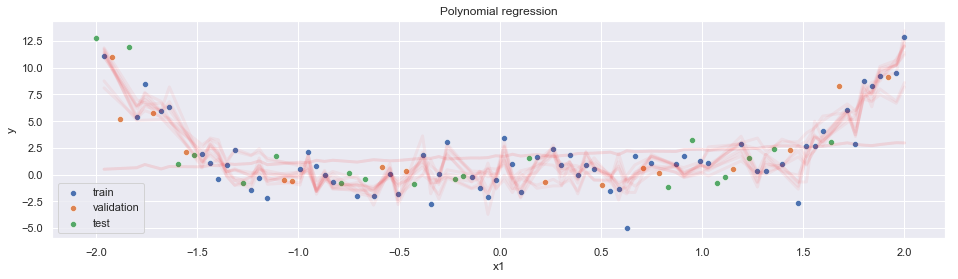

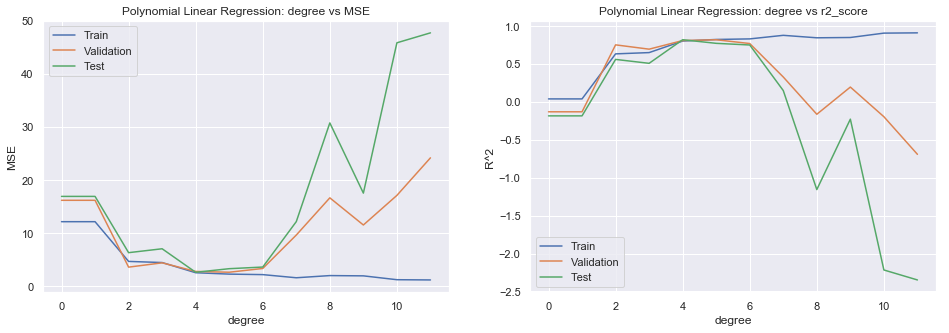

best r2: 0.7692497813625571


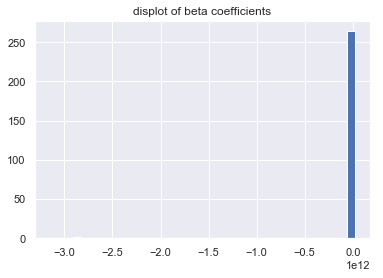

In [38]:
#run make_plots on the data, which will make the plots of the various polynomial regressions and save the r2 of the best model.
best_r2 = make_plots_(train, val, test, max_degree = 12)
print("best r2: {}".format(best_r2)) 
#please note that the best R^2 reported is based on the moodel chosen from the validation set but
#      reported on the test set.
#The faint red lines are the different models being fit for each degree polynomial regression.

### 2) Now standardize the data on the training set and pass the standardized training, validation, and test sets to the make_plots function.

In [25]:
#hint use the fit and transform calls with the StandardScaler class from sklearn.
scaler = #TODO

#assign the standardized datasets here.
train_standard = #TODO
val_standard = #TODO
test_standard = #TODO

SyntaxError: invalid syntax (<ipython-input-25-ff2047b4a11b>, line 2)

In [ ]:
# %load '../solutions/solution1.py'

### 3) Run the make_plots function again by running the cell below then answer the following questions:
1) What degree would you select for a polynomial model based on the $R^2$ plot? <br>
2) Did the $R^2$ and MSE plots change after standardization? <br>
3) Did the values of the beta coefficients change?

In [ ]:
train_standard= pd.DataFrame(train_standard)
val_standard= pd.DataFrame(val_standard)
test_standard = pd.DataFrame(test_standard)

train_standard.columns = ["x1","x2","x3","x4", "y"]
val_standard.columns = ["x1","x2","x3","x4","y"]
test_standard.columns = ["x1","x2","x3","x4","y"]

best_OLS_r2 = make_plots_(train_standard, val_standard, test_standard,  max_degree = 12)
best_OLS_r2

### Bonus question:
**when we split into X_train and y_train as Pavlos does in the class exercises, why is the X capitalized?**

# Regularization

## What is Regularization and why should I care?

When we have a lot of predictors, we need to worry about overfitting. Let's check this out:

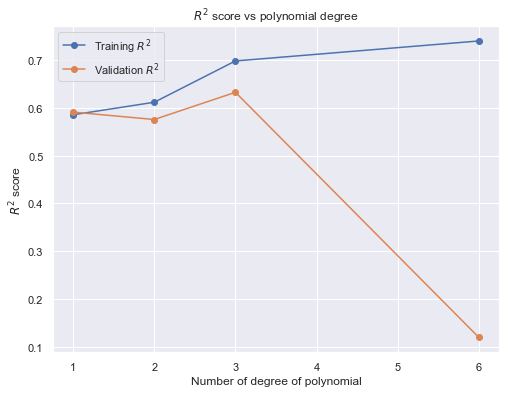

In [39]:
x = [1,2,3,N]
models = [model_1, model_2, model_3, model_N]
X_trains = [X_train_df, X_train_df_2, X_train_df_3, X_train_df_N]
X_vals = [X_val_df, X_val_df_2, X_val_df_3, X_val_df_N]

r2_train = []
r2_val = []

for i,model in enumerate(models):
    y_pred_tra = model.predict(sm.add_constant(X_trains[i]))
    y_pred_val = model.predict(sm.add_constant(X_vals[i]))
    r2_train.append(r2_score(y_train, y_pred_tra))
    r2_val.append(r2_score(y_val, y_pred_val))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, r2_train, 'o-', label=r'Training $R^2$')
ax.plot(x, r2_val, 'o-', label=r'Validation $R^2$')
ax.set_xlabel('Number of degree of polynomial')
ax.set_ylabel(r'$R^2$ score')
ax.set_title(r'$R^2$ score vs polynomial degree')
ax.legend();

We notice a big difference between training and validation R^2 scores: seems like we are overfitting. **Introducing: regularization.**

## What about Multicollinearity?

There's seemingly a lot of multicollinearity in the data. Take a look at this warning that we got when showing our summary for our polynomial models: 

<img src="fig/warning.png" width=400>

What is [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)? Why do we have it in our dataset? Why is this a problem? 

Does regularization help solve the issue of multicollinearity? 

## What does Regularization help with?

We have some pretty large and extreme coefficient values in our most recent models. These coefficient values also have very high variance. We can also clearly see some overfitting to the training set. In order to reduce the coefficients of our parameters, we can introduce a penalty term that penalizes some of these extreme coefficient values. Specifically, regularization helps us: 

1. Avoid overfitting. Reduce features that have weak predictive power.
2. Discourage the use of a model that is too complex

<img src="fig/overfit.png" width="600">

### Big Idea: Reduce Variance by Increasing Bias

Image Source: [here](https://www.cse.wustl.edu/~m.neumann/sp2016/cse517/lecturenotes/lecturenote12.html)

<img src="fig/bias_variance.png" width="600">

## Ridge Regression

Ridge Regression is one such form of regularization. In practice, the ridge estimator reduces the complexity of the model by shrinking the coefficients, but it doesn’t nullify them. We control the amount of regularization using a parameter $\lambda$. **NOTE**: sklearn's [ridge regression package](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) represents this $\lambda$ using a parameter alpha. In Ridge Regression, the penalty term is proportional to the L2-norm of the coefficients. 



<img src="fig/ridge.png" width="400">





## Lasso Regression

Lasso Regression is another form of regularization. Again, we control the amount of regularization using a parameter $\lambda$. **NOTE**: sklearn's [lasso regression package](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) represents this $\lambda$ using a parameter alpha. In Lasso Regression, the penalty term is proportional to the L1-norm of the coefficients. 



<img src="fig/lasso.png" width="400">





### Some Differences between Ridge and Lasso Regression

1. Since Lasso regression tend to produce zero estimates for a number of model parameters - we say that Lasso solutions are **sparse** - we consider to be a method for variable selection.
2. In Ridge Regression, the penalty term is proportional to the L2-norm of the coefficients whereas in Lasso Regression, the penalty term is proportional to the L1-norm of the coefficients.
3. Ridge Regression has a closed form solution! Lasso Regression does not. We often have to solve this iteratively. In the sklearn package for Lasso regression, there is a parameter called `max_iter` that determines how many iterations we perform. 

<img src="fig/3d_ridge_lasso.png" width="800">
<img src="fig/Lasso_formula.png" width="400">
<img src="fig/Ridge_formula.png" width="400">

<img src="fig/ridge_geom_breakdown.png" width="800">
<img src="fig/ridge_geometric.png" width="400">





<img src="fig/lasso_geometric.png" width="400">



### Why Standardizing Variables was not a waste of time

Lasso regression puts constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. It is therefore necessary to standardize the variables. 

## Let's use Ridge and Lasso to regularize our degree N polynomial

**Exercise**: Play around with different values of alpha. Notice the new $R^2$ value and also the range of values that the predictors take in the plot.

R squared score for our original OLS model: 0.11935480685118427
R squared score for Ridge with alpha=100: 0.6535651209719516


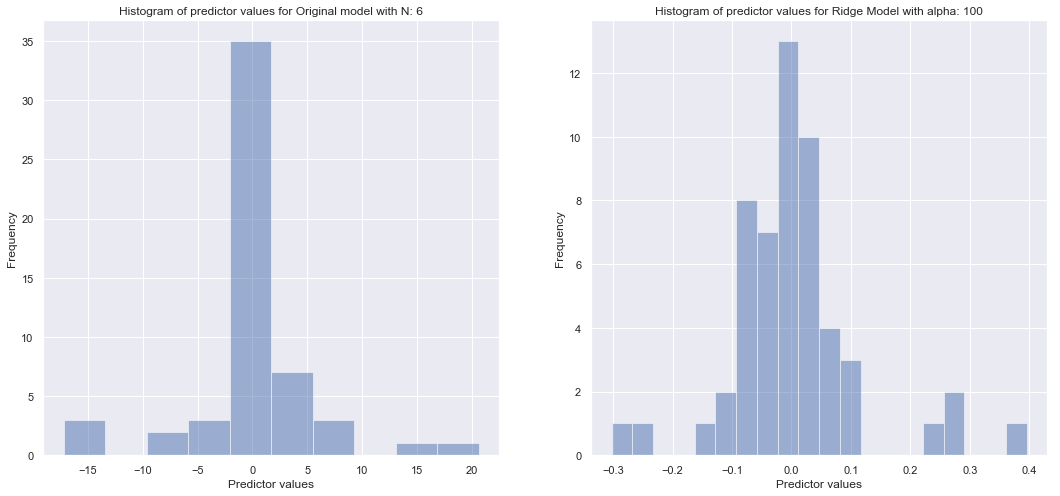

In [40]:
from sklearn.linear_model import Ridge

# some values you can try out: 0.01, 0.1, 0.5, 1, 5, 10, 20, 40, 100, 200, 500, 1000, 10000
alpha = 100
ridge_model = Ridge(alpha=alpha).fit(X_train_df_N, y_train)

print('R squared score for our original OLS model: {}'.format(r2_val[-1]))
print('R squared score for Ridge with alpha={}: {}'.format(alpha, ridge_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.params, bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N))
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(ridge_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Ridge Model with alpha: {}'.format(alpha))
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

R squared score for our original OLS model: 0.11935480685118427
R squared score for Lasso with alpha=0.01: 0.6651205006878169


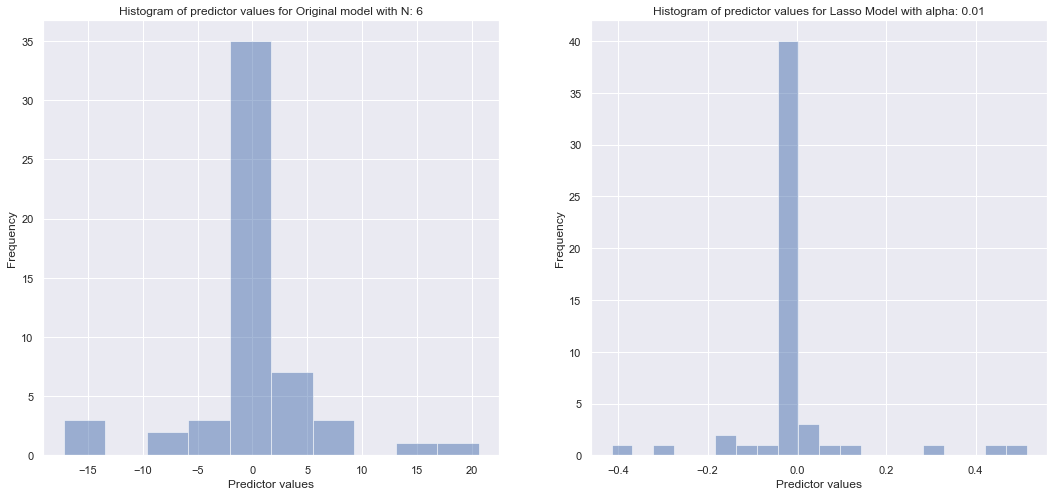

In [41]:
from sklearn.linear_model import Lasso

# some values you can try out: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20
alpha = 0.01
lasso_model = Lasso(alpha=alpha, max_iter = 1000).fit(X_train_df_N, y_train)

print('R squared score for our original OLS model: {}'.format(r2_val[-1]))
print('R squared score for Lasso with alpha={}: {}'.format(alpha, lasso_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.params, bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N))
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(lasso_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Lasso Model with alpha: {}'.format(alpha))
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

## Model Selection and Cross-Validation

Here's our current setup so far: 

<img src="fig/cross_val.png" width="400">


So we try out 10,000 different models on our validation set and pick the one that's the best? No! **Since we could also be overfitting the validation set!** 

One solution to the problems raised by using a single validation set is to evaluate each model on multiple validation sets and average the validation performance. This is the essence of cross-validation!

<img src="fig/cross_val.png" width="700">

Image source: [here](https://medium.com/@sebastiannorena/some-model-tuning-methods-bfef3e6544f0)

Let's give this a try using [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) and [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html):

In [42]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

alphas = (0.001, 0.01, 0.1, 10, 100, 1000, 10000)

# Let us do k-fold cross validation 
k = 4
fitted_ridge = RidgeCV(alphas=alphas).fit(X_train_df_N, y_train)
fitted_lasso = LassoCV(alphas=alphas).fit(X_train_df_N, y_train)

print('R^2 score for our original OLS model: {}\n'.format(r2_val[-1]))

ridge_a = fitted_ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, fitted_ridge.score(X_val_df_N,y_val)))

lasso_a = fitted_lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print('R squared score for Lasso with alpha={}: {}'.format(lasso_a, fitted_lasso.score(X_val_df_N,y_val)))

R^2 score for our original OLS model: 0.11935480685118427

Best alpha for ridge: 1000.0
R^2 score for Ridge with alpha=1000.0: 0.6148040375619066

Best alpha for lasso: 0.01
R squared score for Lasso with alpha=0.01: 0.6651205006878169


We can also look at the coefficients of our CV models.

**Final Step:** report the score on the test set for the model you have chosen to be the best.

## Sklearn's <a href = 'https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html' > cross_validate</a> function:

You may find this useful on the homework. Say you have fit a model on the training set. You will be asked to perform cross validation and score models on the homework based on this function. Below is an example of how to do this. You will also want to choose an appropriate <a href = 'https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter'> scoring method</a>. Please read the documentation for this function. I've included some psuedo-code below:

loss_score = cross_validate(model, X, y, cv=5, scoring = 'r2')

Best R^2 Score: 0.5694057130667505: 


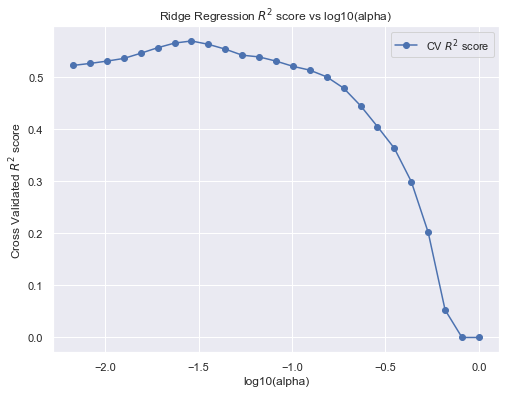

In [47]:
from sklearn.model_selection import cross_validate

#scale the design matrix
X_df = X_train_df_N
X_df = StandardScaler().fit_transform(X_df)
y_train= StandardScaler().fit_transform(y_train)

#alpha values to optimize
alphas = [np.exp(i) for i in np.linspace(-5, 0, 25)]
sklearn_models = []

#fit our various models
for i, alpha in enumerate(alphas):
    model = Lasso(alpha=alpha, max_iter = 1000).fit(X_df, y_train)
    sklearn_models.append(model)

#get the cross validation scores
for i, model in enumerate(sklearn_models):
    #if i == 0 initialize our lists
    if not i:
        r2_train = []
        r2_val = []

    y_pred_tra = model.predict(X_df)
    r2_cv_scores = cross_validate(model, X_df, y_train, cv=5, scoring = 'r2')
    r2_avg_score = np.mean(r2_cv_scores["test_score"])
    r2_train.append(r2_avg_score)
    
#plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.log10(alphas), r2_train, 'o-', label=r'CV $R^2$ score')
ax.set_xlabel('log10(alpha)')
ax.set_ylabel(r'Cross Validated $R^2$ score')
ax.set_title(r'Ridge Regression $R^2$ score vs log10(alpha)')
ax.legend()

print("Best R^2 Score: {}: ".format(np.max(r2_train)))


# Breakout Room 2

1) Fix the fit_ridge_and_lasso_cv function <br>
2) Play with the arguments of the *preprocess* and *fit_ridge_and_lasso_cv* helper functions to try and improve the performance on the test set. <br>
3) Talk with your break out room members about the questions posed

In [45]:
df1 = pd.read_csv("../data/bo_room2.csv")

#Here are your helper functions.
def preprocess(df, standardize = False):
    """Splits the data into training and validation sets.
    arguments:
        df: the dataframe of training and test data you want to split.
        standardize: if True returns standardized data.
    """
    #split the data
    train, test = train_test_split(df, train_size=0.8, random_state = 42)
    
    #sort the data
    train = train.sort_values(by = ["x1"])
    test = test.sort_values(by = ["x1"])

    train.describe()

    X_train, y_train = train[["x1"]], train["y"]
    X_test, y_test = test[["x1"]], test["y"]

    X_train_N = add_higher_order_polynomial_terms(X_train, N=15)
    X_test_N = add_higher_order_polynomial_terms(X_test, N=15)
    
    if standardize:
        scaler = StandardScaler().fit(X_train_N)
        X_train_N = scaler.transform(X_train_N)
        X_test_N = scaler.transform(X_test_N)
    
    #"X_val" : X_val_N, "y_val" : y_val,
    datasets = {"X_train": X_train_N, "y_train":  y_train,  "X_test" : X_test_N, "y_test": y_test}
    return(datasets)


### 1) Fill out the missing lines in this helper function in order to perform cross validated ridge and lasso regression on the synthetic dataset.

In [46]:
def fit_ridge_and_lasso_cv(X_train, y_train,  X_test, y_test,  k = None, alphas = [10**7],
                           best_OLS_r2 = best_OLS_r2): #X_val, y_val,
    """ takes in train and validation test sets and reports the best selected model using ridge and lasso regression.
    Arguments:
        X_train: the train design matrix
        y_train: the reponse variable for the training set
        X_val: the validation design matrix
        y_train: the reponse variable for the validation set
        k: the number of k-fold cross validation sections to be fed to Ridge and Lasso Regularization.
    """

    # Let us do k-fold cross validation. make sure to provide k and alphas as arguments to both ridge and lasso.
    fitted_ridge = #TODO
    fitted_lasso = #TODO
    
    print('R^2 score for our original OLS model: {}\n'.format(best_OLS_r2))

    ridge_a = fitted_ridge.alpha_
    ridge_score = fitted_ridge.score(X_test, y_test)
    print('Best alpha for ridge: {}'.format(ridge_a))
    print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, ridge_score))

    lasso_a = fitted_lasso.alpha_
    lasso_score = fitted_lasso.score(X_test, y_test)
    print('Best alpha for lasso: {}'.format(lasso_a))
    
    print('R^2 score for Lasso with alpha={}: {}'.format(lasso_a, lasso_score))
    
    r2_df = pd.DataFrame({"OLS": best_OLS_r2, "Lasso" : lasso_score, "Ridge" : ridge_score}, index = [0])
    r2_df = r2_df.melt()
    r2_df.columns = ["model", "r2_Score"]
    plt.title("Validation set")
    sns.barplot(x = "model", y = "r2_Score", data = r2_df)
    plt.show()

SyntaxError: invalid syntax (<ipython-input-46-4985d3b00fc4>, line 13)

In [ ]:
# %load "../solutions/solution2.py"

** 1) Run the cell below to see the performance of the OLS, Lasso, and Ridge models on the test set**

In [ ]:
datasets = preprocess(df1)
#Here we input arguments to a function from a dictionary using the ** syntax option.
# X_train, y_train, X_val, y_val,

fit_ridge_and_lasso_cv(**datasets)

**2) How can we improve our results using ridge and lasso (ie boost the $R^2$ score?). Try to play with the arguments of the helper functions to increase the $R^2$ scores and discuss with your group why this works. Don't split the data or try to write your own functions here.**

In [ ]:
#TODO (hint copy and paste the previous cell)


In [ ]:
# %load "../solutions/solution3.py"


***3) Would we in effect be cheating if we optimize our model over k at this stage? Why?***

----------------
### End of Standard Section
---------------